## Example 3: Hand-Eye Calibration

In [1]:
import os
import json

import cv2
import numpy as np
import sophus as sp

import fairotag as frt

DATA_DIR = "data/2_hand_eye_calibration"

NUM_CAMERAS = 3
NUM_SAMPLES = 12

# (id, length)
TABLE_MARKER = (0, 0.1)
EE_MARKER = (8, 0.04)

Instantiate camera modules

In [2]:
with open("data/realsense_intrinsics.json", 'r') as f:
    intrinsics = json.load(f)

camera_modules = []
for _ in range(NUM_CAMERAS):
    c = frt.CameraModule()
    c.set_intrinsics(frt.utils.dict2intrinsics(intrinsics))
    camera_modules.append(c)

Instantiate scene

In [3]:
scene = frt.Scene()

scene.add_frame("ee")
for i, c in enumerate(camera_modules):
    scene.add_camera(f"camera_{i + 1}")

Register markers: In this example we assume there is a marker attached to the static workspace and a marker attached to the end-effector.

In [4]:
# Register markers in cameras
for c in camera_modules:
    for marker in [TABLE_MARKER, EE_MARKER]:
        c.register_marker_size(marker[0], marker[1])

# Register markers in scene
scene.add_marker(TABLE_MARKER[0], length=TABLE_MARKER[1])
scene.add_marker(EE_MARKER[0], length=EE_MARKER[1], frame="ee")

Load calibration data

`ee_poses.npz` contains a dictionary with fields "pos" and "quat", each containing a matrix where the j th row is the position or quaternion of the end-effector in that sample.

`camera<i>_<j>.jpg` contains the image taken from the i th camera at the j th sample.

In [5]:
# Load EE pose data
ee_pose_data = np.load(os.path.join(DATA_DIR, "ee_poses.npz"))

# Load images
imgs_data = []
for j in range(NUM_SAMPLES):
    imgs = []
    for i in range(NUM_CAMERAS):
        filename = os.path.join(DATA_DIR, f"camera{i}_{j}.jpg")
        img = cv2.imread(filename)
        imgs.append(img)
    
    imgs_data.append(imgs)

Add snapshots to scene & solve for extrinsics

Note: The optimization process begins by using BFS to initialize all nodes within the factor graph. `init_node` specifies which node to start the BFS from. `init_node` can be any camera, marker, or frame, and defaults to the world frame if not specified. In this particular set of the hand-eye calibration problem, the world frame (which is the robot base) is not a good initialization point, and thus only by specifying the table marker as the initialization node can the optimization problem work.

In [6]:
# Add snapshots
for j in range(NUM_SAMPLES):
    # Extract sampled EE pose 
    ee_pos = ee_pose_data["pos"][j, :]
    ee_quat = ee_pose_data["quat"][j, :]
    ee_pose = frt.utils.xyz_quat_to_se3(ee_pos, ee_quat)

    # Extract sampled images
    imgs = imgs_data[j]
    marker_obs = [c.detect_markers(img) for c, img in zip(camera_modules, imgs)]

    # Add snapshot
    scene.add_snapshot(
        detected_markers={f"camera_{i + 1}": detected_markers for i, detected_markers in enumerate(marker_obs)},
        frame_transforms=[("world", "ee", ee_pose)],
    )

# Calibrate extrinsics
scene.calibrate_extrinsics(init_node=f"o__{TABLE_MARKER[0]}", verbosity=1)

converged
errorThreshold: 1174.32 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 0 >? 100


Query & vizualize results

{'name': 'camera_1', 'frame': 'world', 'pose': SE3([[   0.99764415998937,  0.0128530549030218,  0.0673864156842067,  0.0111670386598829],
     [-0.0586011652214222,  -0.351020032120598,   0.934532418102627,  -0.912948200878582],
     [ 0.0356655782764891,  -0.936279731720019,  -0.349439881090424,   0.551794583074686],
     [                  0,                   0,                   0,                   1]]), 'pose_in_frame': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'is_anchor': False}
{'name': 'camera_2', 'frame': 'world', 'pose': SE3([[ 0.567560536947371,  0.505290976245119, -0.650043126434905,  0.610495048945605],
     [ 0.822265346291711, -0.307699583036638,  0.478749064632874, -0.449509221442787],
     [0.0418895832849293, -0.806227012648629, -0.590121400127026,  0.663249683015241],
     [                 0,                  0,                  0,                  1]]), 'pose_in_frame': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
 

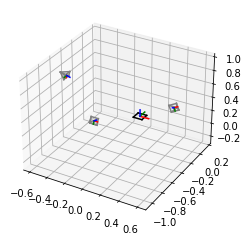

In [7]:
for i in range(NUM_CAMERAS):
    print(scene.get_camera_info(f"camera_{i + 1}"))

scene.visualize()